# Bayes分类器

- 输入类数,特征数,待分样本数
- 输入训练样本数和训练样本集
- 计算先验概率
- 计算各类条件概率密度
- 计算各类的后验概率
- 若按最小错误率原则分类,则根据后验概率判定
- 若按最小风险原则分类,则计算各样本属于各类时的风险并判定

In [1]:
# 导入基本库
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'

 ## 数据预处理

In [2]:
colume_names = ['','gender','height','weight','size']
df= pd.read_excel('data/gender.xlsx',index_col=0,names=colume_names)
df.head(5)

,gender,height,weight,size
,,,,
1,女,163.0,62.0,36.0
2,女,158.0,42.0,36.0
3,男,168.0,67.0,42.0
4,男,180.0,67.0,41.0
5,男,180.0,75.0,46.0


In [3]:
df.shape

(571, 4)

这里可以看到数据有4个维度，分别为性别、身高、体重、鞋码，共有571条记录。下面做一些简单的处理：

In [4]:
# 性别数据转换
df.replace('男',1,inplace=True)
df.replace('女',2,inplace=True)
df.head(5)

,gender,height,weight,size
,,,,
1,2,163.0,62.0,36.0
2,2,158.0,42.0,36.0
3,1,168.0,67.0,42.0
4,1,180.0,67.0,41.0
5,1,180.0,75.0,46.0


In [5]:
# 男生女生数据
male_df = df.loc[df['gender']==1]
female_df = df.loc[df['gender']==2]
female_df.head(5)

,gender,height,weight,size
,,,,
1,2,163.0,62.0,36.0
2,2,158.0,42.0,36.0
9,2,160.0,45.0,36.0
10,2,163.0,48.0,37.0
11,2,161.0,45.0,36.0


## 1、单个特征——身高

为了更加深入得理解贝叶斯分类器原理，我们从简单的一维特征开始。

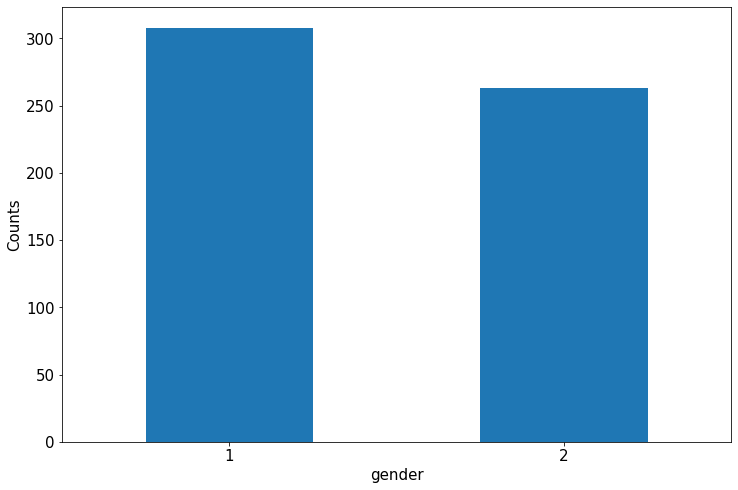

In [6]:
# 男女比例
ax = df['gender'].value_counts().plot(kind = 'bar',figsize = (12,8),fontsize=15,rot = 0)
# 设置x,y轴标签
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('gender',fontsize = 15)

plt.show()

## 类的先验概率估计

类的先验概率可以用训练数据中各类出现的频率来估计，也可以依靠经验来预先确定。这里根据男女学生的人数比例确定先验概率，在测试的时候也可以手动修改。

In [7]:
# 根据男女学生的人数比例确定先验概率: 
# p_w1:男生比例
# p_w2:女生比例
p_w1 = male_df.gender.count()/df.gender.count()
p_w2 = 1-p_w1
p_w1

0.5394045534150613

## 类条件概率密度函数估计

类条件概率密度函数估计主要有两类方法：

- 参数估计：概率密度函数的形式已知，而表征函数的参数未知，通过训练数据估计

    •最大似然估计
    
    •Bayes估计
    
    
- 非参数估计：概率密度函数的形式未知也不作假设，利用训练数据直接对概率密度进行估计

    •Parzen窗法
    
    •kn-近邻法

这里我们采用了参数估计，先对身高数据的分布进行分析，以求找到合适的概率分布模型。

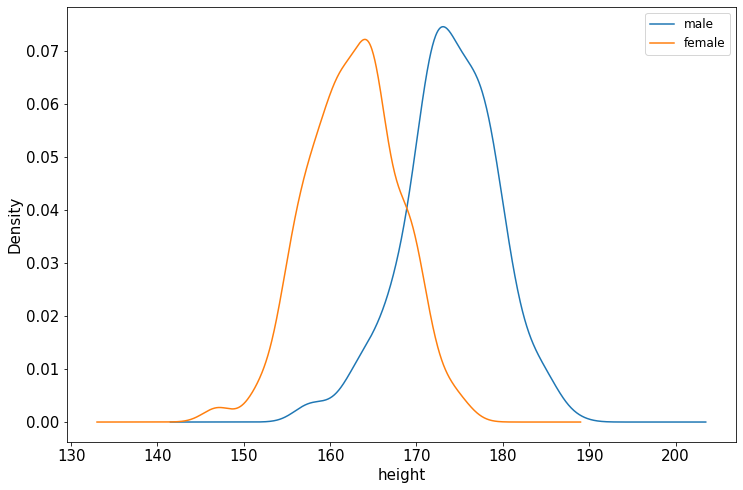

In [8]:
# 男女身高分布
ax = male_df['height'].plot(kind = 'density',figsize = (12,8),fontsize=15)
female_df['height'].plot(kind = 'density',figsize = (12,8),fontsize=15)

ax.legend(['male','female'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('height',fontsize = 15)

plt.show()

从图中可以看，男女生的身高分布没有完全服从正态分布，主要由于样本数量比较少。很多时候，正态分布模型是一个合理假设。在特征空间中，某类样本较多分布在这类均值附近，远离均值的样本较少，一般用正态分布模型是合理的。在后续的实验分析中都将运用正态分布特性对男女生的样本进行分析。

确定好模型以后，我们就要采用合适的方法对模型的参数进行估计，这里使用了最大似然估计，主要计算的参数值有样本的均值和方差。下面是对该参数估计的简单推导。

### *正态分布下的最大似然估计*

仅以单变量正态分布情况估计其均值与方差：$\theta=[\theta_1;\theta_2]=[\mu;\sigma^2]$

单变量正态分布如下：

$p(x|\theta)=\frac{1}{\sqrt{2\pi}\sigma}exp[-\frac{1}{2}(\frac{x-\mu}{\sigma})^2]$

从上述正太分布式可以得到：

$lnp(x_k|\theta)=-\frac{1}{2}ln2\pi\theta_2-\frac{1}{2\theta_2}(x_k-\theta_1)^2$

分别对两个位置参数求偏导，得到：

$\nabla_\theta{lnp(x_k|\theta)}=[\frac{1}{\theta_2}(x_k-\theta_1);-\frac{1}{2\theta_2}+\frac{1}{2\theta_2^2}(x_k-\theta_1)^2]$

最大似然估计应该是以下方程组的解：

$\sum_{k=1}^{N}\frac{1}{\widehat\theta_2}(x_k-\widehat\theta_1)=0$

$-\sum_{k=1}^{N}\frac{1}{\widehat\theta_2}+\sum_{k=1}^{N}\frac{(x_k-\widehat\theta_1)^2}{\widehat\theta_2^2}=0$

解得：

$\widehat\mu=\widehat\theta_1=\frac{1}{N}\sum_{k=1}^{N}x_k$......................(2.1)      

$\widehat{\sigma^2}=\widehat\theta_2=\frac{1}{N}\sum_{k=1}^{N}(x_k-\widehat\mu)^2$..........(2.2)

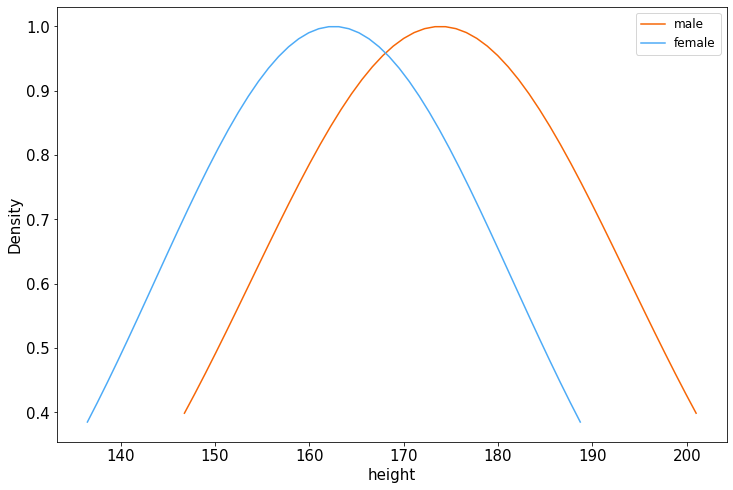

In [9]:
# 采用最大似然估计方法，求男女生身高分布的参数并可视化

plt.figure(figsize = (12,8))
plt.ylabel('Density',fontsize = 15)
plt.xlabel('height',fontsize = 15)

# 均值
u1 = male_df.height.mean()
#标准差 
sig1 = math.sqrt(male_df.height.var())

x1 = np.linspace(u1 - 5 * sig1, u1 + 5 * sig1)
y_sig1 = np.exp(-(x1 - u1) ** 2 / (2 * sig1 ** 2) / (math.sqrt(2 * math.pi) * sig1))

plt.xticks(size = 15)
plt.yticks(size = 15)
plt.plot(x1,y_sig1,"-",color='#f76707')

# 均值
u2 = female_df.height.mean()
#标准差 
sig2 = math.sqrt(female_df.height.var())

x2 = np.linspace(u2 - 5 * sig2, u2 + 5 * sig2)
y_sig2 = np.exp(-(x2 - u2) ** 2 / (2 * sig2 ** 2) / (math.sqrt(2 * math.pi) * sig2))
plt.plot(x2,y_sig2,"-",color='#4dabf7')
plt.legend(['male','female'],fontsize = 12)

plt.show()

下面采用两种分类方法进行判定：

## 按最小错误率原则分类，则根据后验概率判定

In [10]:
# 决策
def bayes_classifier_lowest_error(x):
    # p_w1:男生先验概率
    # p_w2:女生先验概率
    # y_sig1:男生后验概率
    # y_sig2:女生后验概率
    y_sig1 = np.exp(-(x - u1) ** 2 / (2 * sig1 ** 2) / (math.sqrt(2 * math.pi) * sig1))
    y_sig2 = np.exp(-(x - u2) ** 2 / (2 * sig2 ** 2) / (math.sqrt(2 * math.pi) * sig2))
    print('y_sig1 = %.2f' %y_sig1)
    print('y_sig2 = %.2f' %y_sig2)
    # 判别结果  
    result = p_w1*y_sig1-p_w2*y_sig2
    if result > 0:
        return 'male'
    else:
        return 'female'

In [11]:
# 测试
bayes_classifier_lowest_error(170)

y_sig1 = 0.98
y_sig2 = 0.93


'male'

## 若按最小风险原则分类,则计算各样本属于各类时的风险并判定

In [12]:
# 最小风险原则决策
def bayes_classifier_lowest_risk(x):
    # p_r1:风险因子
    # p_r2:风险因子
    p_r1 = 4
    p_r2 = 2
    # y_sig1:男生后验概率
    # y_sig2:女生后验概率
    y_sig1 = np.exp(-(x - u1) ** 2 / (2 * sig1 ** 2) / (math.sqrt(2 * math.pi) * sig1))
    y_sig2 = np.exp(-(x - u2) ** 2 / (2 * sig2 ** 2) / (math.sqrt(2 * math.pi) * sig2))
    print('y_sig1 = %.2f' %y_sig1)
    print('y_sig2 = %.2f' %y_sig2)
    # 判别结果  
    result = p_r2*y_sig1-p_r1*y_sig2
    if result > 0:
        return 'male'
    else:
        return 'female'

In [13]:
# 简单测试
bayes_classifier_lowest_risk(170)

y_sig1 = 0.98
y_sig2 = 0.93


'female'

可以看到两种不同的分类原则得到了截然相反的结果，我们再继续对其他数据进行验证，看看最终的结果。下面我们对两种分类方法进行封装，并做交叉验证和ROC曲线分析。

## 封装成类

In [14]:
# 按最小错误率原则分类，则根据后验概率判定
class bayes_error():
    def __init__(self):
        self.p1 = self.p2 = self.u1 = self.sig1 = self.u2 = self.sig2 = 0
        self.pro = pd.DataFrame(columns=['cate1','cate2'])
    # 训练

    def fit(self, x_train, y_train):
        # 根据男女学生的人数比例确定先验概率:
        # p_w1:男生比例
        # p_w2:女生比例
        x_train = x_train.values
        y_train = y_train.values
        male_num = female_num = 0
        male_df = []
        female_df = []
        for i in range(len(y_train)):
            if (y_train[i] == 1):
                male_num += 1
                male_df.append(x_train[i])
            elif (y_train[i] == 2):
                female_num += 1
                female_df.append(x_train[i])
            else:
                pass

        # p_w1:男生先验概率
        # p_w2:女生先验概率
        self.p_w1 = male_num / len(y_train)
        self.p_w2 = female_num / len(y_train)

        # 估计概率分布
        self.u1 = np.mean(male_df)
        self.sig1 = math.sqrt(np.var(male_df))
        self.u2 = np.mean(female_df)
        self.sig2 = math.sqrt(np.var(female_df))

    # 预测
    def predict(self, x_test):
        x_test = x_test.values
        y_predict = []
        # 判别
        for i in range(len(x_test)):
            # p_w1:男生先验概率
            # p_w2:女生先验概率
            # y_sig1:男生后验概率
            # y_sig2:女生后验概率
            x = x_test[i]
            y_sig1 = np.exp(-(x - self.u1) ** 2 / (2 * self.sig1 ** 2) /
                            (math.sqrt(2 * math.pi) * self.sig1))
            y_sig2 = np.exp(-(x - self.u2) ** 2 / (2 * self.sig2 ** 2) /
                            (math.sqrt(2 * math.pi) * self.sig2))
            result = self.p_w1*y_sig1 - self.p_w2*y_sig2
            g_1 = self.p_w1*y_sig1
            g_2 = self.p_w2*y_sig2
            self.pro.loc[i] = [g_1[0],g_2[0]]
            if result > 0:
                y_predict.append(1)
            else:
                y_predict.append(2)

        return y_predict
    def predict_proba(self,x_test):
        return self.pro.values

In [15]:
# 按最小风险原则分类,则计算各样本属于各类时的风险并判定
class bayes_risk():
    def __init__(self):
        self.u1=self.sig1=self.u2=self.sig2=0
        # p_r1:风险因子
        # p_r2:风险因子
        self.p_r1 = 2
        self.p_r2 = 2
        self.pro = pd.DataFrame(columns=['cate1','cate2'])

    # 训练

    def fit(self, x_train, y_train):
        x_train = x_train.values
        y_train = y_train.values
        # 根据男女学生的人数比例确定先验概率:
        # p_w1:男生比例
        # p_w2:女生比例

        male_df = []
        female_df = []
        for i in range(len(y_train)):
            if (y_train[i] == 1):
                male_df.append(x_train[i])
            elif (y_train[i] == 2):
                female_df.append(x_train[i])
            else:
                pass

        # 估计概率分布
        self.u1 = np.mean(male_df)
        self.sig1 = math.sqrt(np.var(male_df))
        self.u2 = np.mean(female_df)
        self.sig2 = math.sqrt(np.var(female_df))

    # 预测
    def predict(self, x_test):
        x_test = x_test.values
        y_predict = []
        # 判别
        for i in range(len(x_test)):
            # y_sig1:男生后验概率
            # y_sig2:女生后验概率
            x = x_test[i]
            y_sig1 = np.exp(-(x - self.u1) ** 2 / (2 * self.sig1 ** 2) /
                            (math.sqrt(2 * math.pi) * self.sig1))
            y_sig2 = np.exp(-(x - self.u2) ** 2 / (2 * self.sig2 ** 2) /
                            (math.sqrt(2 * math.pi) * self.sig2))
            result = self.p_r2*y_sig1-self.p_r1*y_sig2
            g_1 = self.p_r1*y_sig1
            g_2 = self.p_r2*y_sig2
            self.pro.loc[i] = [g_1[0],g_2[0]]
            if result > 0:
                y_predict.append(1)
            else:
                y_predict.append(2)
        return y_predict
    def predict_proba(self,x_test):
        return self.pro.values

## 交叉验证

In [16]:
# 数据提取
data = df[['height','gender']].copy()
data.head(5)

,height,gender
,,
1,163.0,2
2,158.0,2
3,168.0,1
4,180.0,1
5,180.0,1


In [17]:
X = data.iloc[:,0:1] # 特征
Y = data.iloc[:,1] # 标签

In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

k = 10
kf = KFold(n_splits=k,shuffle=True)

In [20]:
# 贝叶斯风险
accuracies = []
tprs1 = []
aucs1 = []
mean_fpr1 = np.linspace(0, 1, 100)
i = 0

for train_index, test_index in kf.split(data):  # 拆分

    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    model = bayes_risk()  # 模型原型 选择
    model.fit(x_train, y_train)  # 训练
    y_predict = model.predict(x_test)  # 预测

    # predict_proba()方法返回一个数组，其中每一行是一个样本，而每一列则是一个类别，每一条数据包含给定实例属于该给定类别的概率
    y_probas = model.predict_proba(x_test)
    y_scores = y_probas[:, 1]  # score = proba of positive class

    fpr, tpr, thersholds = roc_curve(
        y_test, y_scores, pos_label=2)  # roc_curve()函数计算不同阈值的TPR和FPR

    # interp:插值 把结果添加到tprs列表中
    tprs1.append(np.interp(mean_fpr1, fpr, tpr))
    tprs1[-1][0] = 0.0
    # 计算auc
    roc_auc = auc(fpr, tpr)
    aucs1.append(roc_auc)
    
    accuracy = accuracy_score(y_pred=y_predict, y_true=y_test)
    accuracies.append(accuracy)
    i += 1

# 平均错误率
print('bayes_risk average: ', np.mean(accuracies))

bayes_risk average:  0.852843315184513


In [21]:
accuracies = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0

for train_index, test_index in kf.split(data):  # 拆分

    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    model = bayes_error()  # 模型原型 选择
    model.fit(x_train, y_train)  # 训练
    y_predict = model.predict(x_test)  # 预测

    # predict_proba()方法返回一个数组，其中每一行是一个样本，而每一列则是一个类别，每一条数据包含给定实例属于该给定类别的概率
    y_probas = model.predict_proba(x_test)
    y_scores = y_probas[:, 1]  # score = proba of positive class

    fpr, tpr, thersholds = roc_curve(
        y_test, y_scores, pos_label=2)  # roc_curve()函数计算不同阈值的TPR和FPR

    # interp:插值 把结果添加到tprs列表中
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    # 计算auc
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    accuracy = accuracy_score(y_pred=y_predict, y_true=y_test)
    accuracies.append(accuracy)
    i += 1

# 平均错误率
print('bayes_error average: ', np.mean(accuracies))

bayes_error average:  0.7406836055656381


绘制ROC曲线参考：博客[https://blog.csdn.net/DoReAGON/article/details/89290691?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-7.control&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-7.control]

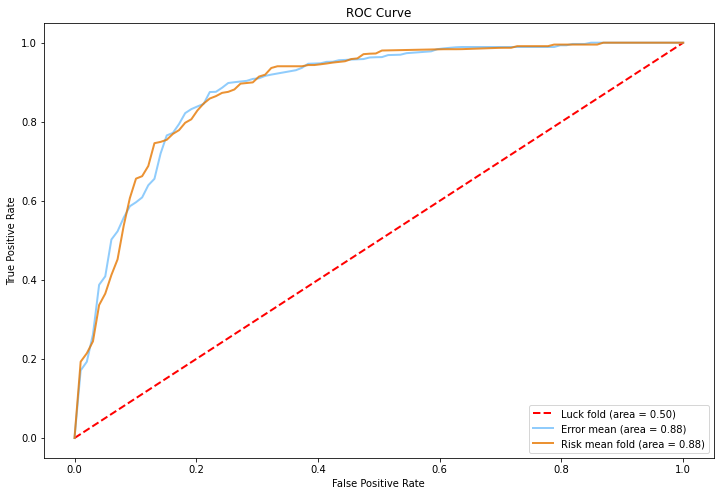

In [22]:
# 绘制ROC曲线对比图
plt.figure(figsize=(12, 8))
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])


plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--',
         label='Luck fold (area = {0:.2f})'.format(0.5))  # 绘制对角线

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)  # 计算平均AUC值
std_auc = np.std(tprs, axis=0)
plt.plot(mean_fpr, mean_tpr, color='#74c0fc',
         label='Error mean (area = {0:.2f})'.format(mean_auc), lw=2, alpha=.8)

mean_tpr1 = np.mean(tprs1, axis=0)
mean_tpr1[-1] = 1.0
mean_auc1 = auc(mean_fpr1, mean_tpr1)  # 计算平均AUC值
std_auc1 = np.std(tprs1, axis=0)
plt.plot(mean_fpr1, mean_tpr1, color='#e67700',
         label='Risk mean fold (area = {0:.2f})'.format(mean_auc1), lw=2, alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

从比较ROC曲线宏平均结果，发现按最小错误率原则分类和按最小风险原则分类两者的RO曲线重合率较高，且AUC面积都接近0.9,说明两种分类器性能都较为稳定。

## 2、二维特征——身高、体重

从一维扩展到二维甚至更高维，关键就是将单个特征的运算转化成特征向量的运算。下面以二维特征的身高和体重为例，分析如何设计多个特征的贝叶斯分类器。

In [23]:
# 数据提取
data = df[['height','weight','gender']].copy()
data.columns = ['feature1', 'feature2', 'category']
data.head(5)

,feature1,feature2,category
,,,
1,163.0,62.0,2
2,158.0,42.0,2
3,168.0,67.0,1
4,180.0,67.0,1
5,180.0,75.0,1


In [24]:
cate1_df = data.loc[data['category']==1]
cate2_df = data.loc[data['category']==2]

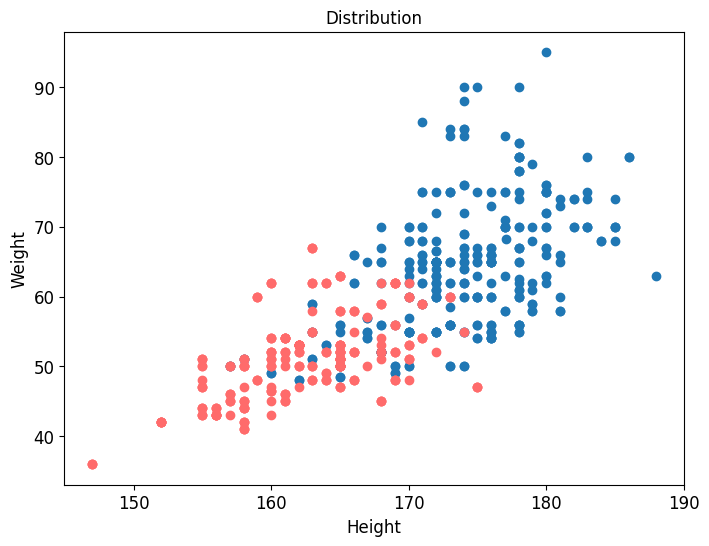

In [25]:
# 二元高斯概率分布图水平面投影
plt.figure(figsize=(8,6),dpi=100)
plt.scatter(cate1_df.feature1, cate1_df.feature2)
plt.scatter(cate2_df.feature1, cate2_df.feature2,color='#ff6b6b')
plt.xlabel('Height',fontsize=12)
plt.ylabel('Weight',fontsize=12) 
plt.title('Distribution',fontsize=12)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

In [26]:
# 根据比例确定先验概率:
num = list(data['category'].value_counts())
male_num = num[0]
female_num = num[1]
p_w1 = male_num / (num[0]+num[1])
p_w2 = female_num / (num[0]+num[1])
num

[308, 263]

https://www.cnblogs.com/Determined22/p/6347778.html

- 多元高斯密度下的判别函数

    $ g_i(x)=-\frac{1}{2}(x-\mu_i)^T\sum_i^{-1}(x-\mu_i)-\frac{1}{2}|\sum_i|+lnP(w_i) $


- 简化

    如果做一定的简化，认为各个类别的协方差矩阵都相等$\sum_i = \sum$ ，将上式展开化简，可得到线性判别函数:

    $ g_i(x)=（\mu_i^T\sum^{-1}x-\frac{1}{2}\mu_i^T\sum^{-1}\mu_i+lnP(w_i)$

In [27]:
# 估计概率分布 (计算样本期望 μ 和 协方差 cov)

u1_1 = cate1_df.feature1.mean()
u1_2 = cate1_df.feature2.mean()
u1 = np.array([u1_1, u1_2])
u2_1 = cate2_df.feature1.mean()
u2_2 = cate2_df.feature2.mean()
u2 = np.array([u2_1, u2_2])

# 协方差矩阵
cov1_1 = cate1_df.feature1.cov(cate1_df.feature1)
cov1_2 = cate1_df.feature1.cov(cate1_df.feature2)
cov1_3 = cate1_df.feature2.cov(cate1_df.feature1)
cov1_4 = cate1_df.feature2.cov(cate1_df.feature2)
cov1 = np.array([[cov1_1, cov1_2], [cov1_3, cov1_4]])

cov2_1 = cate2_df.feature1.cov(cate2_df.feature1)
cov2_2 = cate2_df.feature1.cov(cate2_df.feature2)
cov2_3 = cate2_df.feature2.cov(cate2_df.feature1)
cov2_4 = cate2_df.feature2.cov(cate2_df.feature2)
cov2 = np.array([[cov2_1, cov2_2], [cov2_3, cov2_4]])
print(cov1,'\n',cov2)

[[29.40047665 24.98623789]
 [24.98623789 82.17291372]] 
 [[27.27968537 17.43315967]
 [17.43315967 35.26327925]]


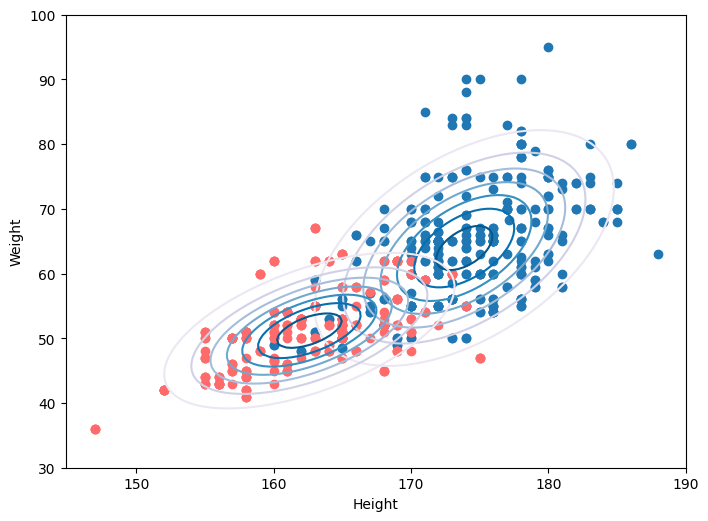

In [28]:
# 可视化类概率分布
from scipy import stats

x = np.linspace(150, 190, 100)
y = np.linspace(30, 100, 100)
x, y = np.meshgrid(x, y)
pos = np.dstack((x, y))

z1 = stats.multivariate_normal.pdf(pos, mean=u1, cov=cov1)
z2 = stats.multivariate_normal.pdf(pos, mean=u2, cov=cov2)

plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(cate1_df.feature1, cate1_df.feature2)
plt.scatter(cate2_df.feature1, cate2_df.feature2, color='#ff6b6b')


plt.contour(x, y, z1, cmap='PuBu')
plt.contour(x, y, z2, cmap='PuBu')


plt.xlabel('Height')
plt.ylabel('Weight')

plt.show()

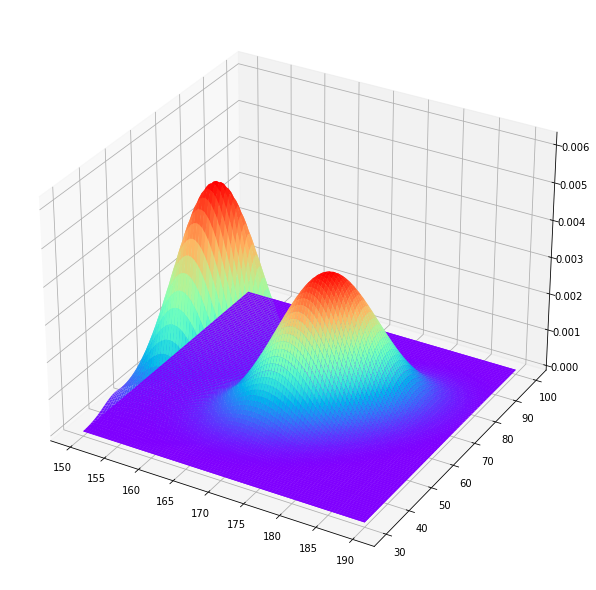

In [29]:
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(150, 190,100)
y = np.linspace(30, 100,100)
X, Y = np.meshgrid(x, y)
pos = np.empty(X.shape + (2, ))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z1 = stats.multivariate_normal.pdf(pos, mean=u1, cov=cov1)
Z2 = stats.multivariate_normal.pdf(pos, mean=u2, cov=cov2)


fig = plt.figure(figsize=(12,8))
ax = Axes3D(fig)

# 具体函数方法可用 help(function) 查看，如：help(ax.plot_surface)
ax.plot_surface(X, Y, Z1, rstride=1, cstride=1, cmap='rainbow')
ax.plot_surface(X, Y, Z2, rstride=1, cstride=1, cmap='rainbow')
plt.show()

In [30]:
# 预测

def Bayes_2d_test(a):
    g_1 = -0.5*(x-u1).dot(np.linalg.inv(cov1)).dot(x-u1)
    -0.5*np.log(abs(cov1))+np.log(p_w1)
    g_2 = -0.5*(x-u2).dot(np.linalg.inv(cov2)).dot(x-u2)
    -0.5*np.log(abs(cov2))+np.log(p_w2)

    result = g_1 - g_2
    if result > 0:
        return 1
    else:
        return 2
    
x = [168.0,51.0]
Bayes_2d_test(x)

2

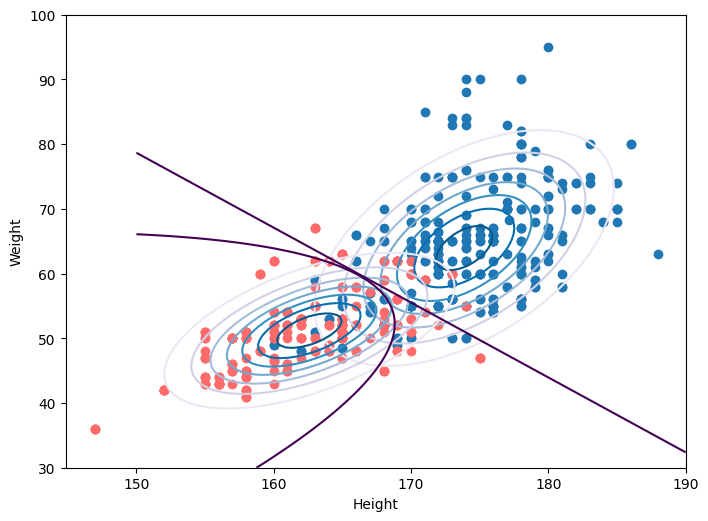

In [31]:
# 可视化类概率分布
from scipy import stats

x = np.linspace(150, 190, 100)
y = np.linspace(30, 100, 100)
x, y = np.meshgrid(x, y)
pos = np.dstack((x, y))

z1 = stats.multivariate_normal.pdf(pos, mean=u1, cov=cov1)
z2 = stats.multivariate_normal.pdf(pos, mean=u2, cov=cov2)

# 绘制分界线
# 1:不相互独立
def dependent(x,y):
    v1 = np.linalg.inv(cov1)
    v2 = np.linalg.inv(cov2)
    g1 = -0.5*(((x-u1_1)*v1[0][0]+(y-u1_2)*v1[1][0])*(x-u1_1) +
               ((x-u1_1)*v1[0][1]+(y-u1_2)*v1[1][1])*(y-u1_2))
    -0.5*np.log(abs(cov1))+np.log(p_w1)
    g2 = -0.5*(((x-u2_1)*v2[0][0]+(y-u2_2)*v2[1][0])*(x-u2_1) +
               ((x-u2_1)*v2[0][1]+(y-u2_2)*v2[1][1])*(y-u2_2))
    -0.5*np.log(abs(cov2))+np.log(p_w2)
    return g1-g2
z3 = dependent(x,y)

# 2：相互独立
def independent(x,y):
    v1 = np.linalg.inv(cov2)
    v2 = np.linalg.inv(cov2)
    g1 = -0.5*(((x-u1_1)*v1[0][0]+(y-u1_2)*v1[1][0])*(x-u1_1) +
               ((x-u1_1)*v1[0][1]+(y-u1_2)*v1[1][1])*(y-u1_2))
    -0.5*np.log(abs(cov1))+np.log(p_w1)
    g2 = -0.5*(((x-u2_1)*v2[0][0]+(y-u2_2)*v2[1][0])*(x-u2_1) +
               ((x-u2_1)*v2[0][1]+(y-u2_2)*v2[1][1])*(y-u2_2))
    -0.5*np.log(abs(cov2))+np.log(p_w2)
    return g1-g2
z4 = independent(x,y)

plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(cate1_df.feature1, cate1_df.feature2)
plt.scatter(cate2_df.feature1, cate2_df.feature2, color='#ff6b6b')


plt.contour(x, y, z1, cmap='PuBu')
plt.contour(x, y, z2, cmap='PuBu')
plt.contour(x, y, z3,[0])
plt.contour(x, y, z4,[0])

plt.xlabel('Height')
plt.ylabel('Weight')

plt.show()

## 封装函数

In [32]:
# 按最小错误率原则分类，则根据后验概率判定
class bayes_error_2d():
    def __init__(self):
        # 先验概率
        self.p_w1 = 0
        self.p_w2 = 0
        # 均值
        self.u1 = []
        self.u2 = []
        # 协方差矩阵
        self.cov1 = []
        self.cov2 = []
        # 概率值
        self.pro = pd.DataFrame(columns=['cate1','cate2'])

    # 训练

    def fit(self, x_train, y_train):

        # 根据比例确定先验概率:
        num = list(y_train.value_counts())
        male_num = num[0]
        female_num = num[1]

        self.p_w1 = male_num / len(y_train)
        self.p_w2 = female_num / len(y_train)

        cate_df = pd.concat([x_train, y_train], axis=1)
        cate_df.columns = ['feature1', 'feature2', 'category']
        cate1_df = cate_df.loc[cate_df['category'] == 1]
        cate2_df = cate_df.loc[cate_df['category'] == 2]

        # 估计概率分布 (计算样本期望 μ 和 协方差 cov)
        u1_1 = cate1_df.feature1.mean()
        u1_2 = cate1_df.feature2.mean()
        self.u1 = np.array([u1_1, u1_2])
        u2_1 = cate2_df.feature1.mean()
        u2_2 = cate2_df.feature2.mean()
        self.u2 = np.array([u2_1, u2_2])

        # 协方差矩阵
        cov1_1 = cate1_df.feature1.cov(cate1_df.feature1)
        cov1_2 = cate1_df.feature1.cov(cate1_df.feature2)
        cov1_3 = cate1_df.feature2.cov(cate1_df.feature1)
        cov1_4 = cate1_df.feature2.cov(cate1_df.feature2)
        self.cov1 = np.array([[cov1_1, cov1_2], [cov1_3, cov1_4]])
        cov2_1 = cate2_df.feature1.cov(cate2_df.feature1)
        cov2_2 = cate2_df.feature1.cov(cate2_df.feature2)
        cov2_3 = cate2_df.feature2.cov(cate2_df.feature1)
        cov2_4 = cate2_df.feature2.cov(cate2_df.feature2)
        self.cov2 = np.array([[cov2_1, cov2_2], [cov2_3, cov2_4]])

    # 预测
    def predict(self, x_test):
        x_test = x_test.values
        y_predict = []
        # 判别
        for i in range(len(x_test)):
            # p_w1:category1先验概率
            # p_w2:category2先验概率
            x = x_test[i]
            g_1 = -0.5*(x-self.u1).dot(np.linalg.inv(self.cov1)).dot(x-self.u1)
            -0.5*np.log(abs(self.cov1))+np.log(self.p_w1)
            g_2 = -0.5*(x-self.u2).dot(np.linalg.inv(self.cov2)).dot(x-self.u2)
            -0.5*np.log(abs(self.cov2))+np.log(self.p_w2)

            result = g_1 - g_2
            if result > 0:
                y_predict.append(1)
            else:
                y_predict.append(2)
            self.pro.loc[i] = [g_1,g_2]
        return y_predict

    # predict_proba()方法返回一个数组，其中每一行是一个样本，而每一列则是一个类别，每一条数据包含给定实例属于该给定类别的概率

    def predict_proba(self, x_test):
        return self.pro.values

## 交叉测试

In [33]:
X = data.iloc[:,0:2] # 特征
Y = data.iloc[:,2] # 标签

In [34]:
from sklearn.model_selection import KFold

k = 10
kf = KFold(n_splits=k,shuffle=True)

bayes_error 第1轮: 0.8275862068965517
bayes_error 第2轮: 0.8596491228070176
bayes_error 第3轮: 0.7192982456140351
bayes_error 第4轮: 0.8421052631578947
bayes_error 第5轮: 0.8771929824561403
bayes_error 第6轮: 0.7894736842105263
bayes_error 第7轮: 0.8596491228070176
bayes_error 第8轮: 0.7894736842105263
bayes_error 第9轮: 0.9122807017543859
bayes_error 第10轮: 0.8421052631578947
bayes_error average:  0.831881427707199


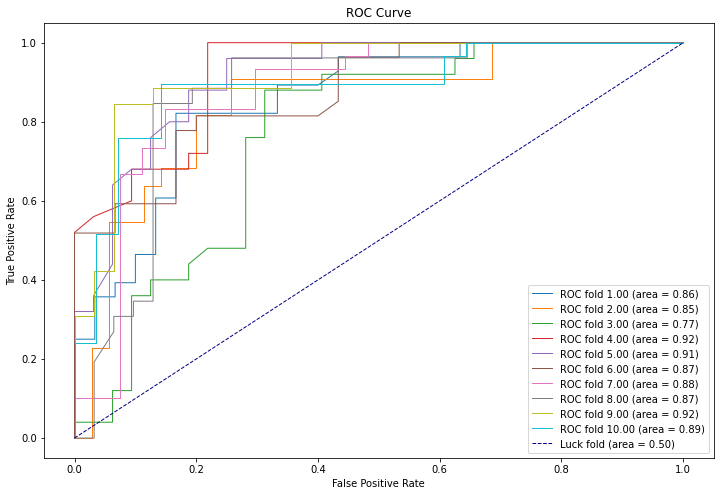

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
accuracies = []
i = 0
plt.figure(figsize=(12, 8))
for train_index, test_index in kf.split(data):  # 拆分

    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    model = bayes_error_2d()  # 模型原型 选择
#     model = tree.DecisionTreeClassifier()  # 模型原型 选择

    model.fit(x_train, y_train)  # 训练
    y_predict = model.predict(x_test)  # 预测

    # predict_proba()方法返回一个数组，其中每一行是一个样本，而每一列则是一个类别，每一条数据包含给定实例属于该给定类别的概率
    y_probas = model.predict_proba(x_test)
    y_scores = y_probas[:, 1]  # score = proba of positive class

    fpr, tpr, thersholds = roc_curve(
        y_test, y_scores, pos_label=2)  # roc_curve()函数计算不同阈值的TPR和FPR

    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold {0:.2f} (area = {1:.2f})'.format(
        i+1, roc_auc))    # 画出当前分割数据的ROC曲线

    accuracy = accuracy_score(y_pred=y_predict, y_true=y_test)
    accuracies.append(accuracy)
    i += 1
    print('bayes_error 第{}轮: {}'.format(i, accuracy))

print('bayes_error average: ', np.mean(accuracies))

plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--',
         label='Luck fold (area = {1:.2f})'.format(i+1, 0.5))  # 绘制对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## ROC曲线

- ROC曲线：接收者操作特征曲线（receiver operating characteristic curve），是反映敏感性和特异性连续变量的综合指标，roc曲线上每个点反映着对同一信号刺激的感受性。

- 横轴：负正类率(false postive rate FPR)特异度，划分实例中负例占所有负例的比例；(1-Specificity)

- 纵轴：真正类率(true postive rate TPR)灵敏度，Sensitivity(正类覆盖率)

    针对一个二分类问题，将实例分成正类(postive)或者负类(negative)。但是实际中分类时，会出现四种情况.

    (1)若一个实例是正类并且被预测为正类，即为真正类(True Postive TP)

    (2)若一个实例是正类，但是被预测成为负类，即为假负类(False Negative FN)

    (3)若一个实例是负类，但是被预测成为正类，即为假正类(False Postive FP)

    (4)若一个实例是负类，但是被预测成为负类，即为真负类(True Negative TN)

    TP:正确的肯定数目

    FN:漏报，没有找到正确匹配的数目

    FP:误报，没有的匹配不正确

    TN:正确拒绝的非匹配数目


- 横，纵轴的计算公式：

    (1)真正类率(True Postive Rate)TPR: TP/(TP+FN),代表分类器预测的正类中实际正实例占所有正实例的比例。Sensitivity

    (2)负正类率(False Postive Rate)FPR: FP/(FP+TN),代表分类器预测的正类中实际负实例占所有负实例的比例。1-Specificity

    (3)真负类率(True Negative Rate)TNR: TN/(FP+TN),代表分类器预测的负类中实际负实例占所有负实例的比例，TNR=1-FPR。Specificity

- AUC：一个正例，一个负例，预测为正的概率值比预测为负的概率值还要大的可能性。

- 计算AUC的方法:

    1：绘制ROC曲线，ROC曲线下面的面积就是AUC的值

    2：假设总共有（m+n）个样本，其中正样本m个，负样本n个，总共有m*n个样本对，计数，正样本预测为正样本的概率值大于负样本预测为正样本的概率值记为1，累加计数，然后除以（m*n）就是AUC的值

- ROC曲线宏平均

宏平均指n条ROC曲线的平均。根据all_fpr（代表横坐标值，所以去除重复并排序），当前类的fpr和tpr决定的当前类的ROC曲线，利用interp函数对fpr中相对all_fpr不存在的横坐标进行插值（横向顶点间的纵坐标值相等），得到插值后的tpr（与all_fpr等长），对n类插值后的tpr求和取平均得到mean_tpr，最后根据all_fpr和mean_fpr画出最终的ROC曲线。